In [1]:
import sys, os
import pandas as pd
%matplotlib inline

import numpy as np

import datetime

DATE = lambda: datetime.datetime.now().strftime("[%m/%d/%Y %H:%M:%S]")

import gseapy
gseapy.get_library_name()
gs_list = [
    'COVID-19_Related_Gene_Sets', 'MSigDB_Hallmark_2020',
    'GO_Biological_Process_2018', 'KEGG_2019_Mouse'
]
gs_list[2:4]

['GO_Biological_Process_2018', 'KEGG_2019_Mouse']

# load bootstrap's results

In [101]:
df_feature_genes.sort_values('avg_weight').to_csv('bootstrap_features.csv')
df_feature_genes[df_feature_genes.counts >= 90].sort_values(
    'avg_weight').to_csv('bootstrap_features_selected.csv')

In [2]:
import pickle
bootstrap_result_dict = pickle.load(open('bootstrap_result_dict.p', 'rb'))
features_list=bootstrap_result_dict['features_list']
del bootstrap_result_dict
len(features_list)

100

# genes with Negative weight

In [4]:
go_res_dict={}

In [3]:
%%time
gs_res_dict = {}
for i in range(100):
    if (i % 5 == 0): print(DATE(), f'running enrichr on negative set {i}')
    gs_res = gseapy.enrichr(
        gene_list=features_list[i].gene[features_list[i].coef < 0].to_list(),
        description=gs_list[2],
        outdir='down',
        no_plot=True,
        gene_sets=gs_list[2])
    gs_res_dict[i] = gs_res.res2d[gs_res.res2d['Adjusted P-value'] < 0.01]

[06/03/2021 23:56:38] running enrichr on negative set 0
[06/03/2021 23:57:10] running enrichr on negative set 5
[06/03/2021 23:57:45] running enrichr on negative set 10
[06/03/2021 23:58:11] running enrichr on negative set 15
[06/03/2021 23:58:48] running enrichr on negative set 20
[06/03/2021 23:59:36] running enrichr on negative set 25
[06/04/2021 00:00:11] running enrichr on negative set 30
[06/04/2021 00:00:40] running enrichr on negative set 35
[06/04/2021 00:01:14] running enrichr on negative set 40
[06/04/2021 00:01:53] running enrichr on negative set 45
[06/04/2021 00:02:16] running enrichr on negative set 50
[06/04/2021 00:02:39] running enrichr on negative set 55
[06/04/2021 00:03:15] running enrichr on negative set 60
[06/04/2021 00:03:42] running enrichr on negative set 65
[06/04/2021 00:04:24] running enrichr on negative set 70
[06/04/2021 00:04:51] running enrichr on negative set 75
[06/04/2021 00:05:19] running enrichr on negative set 80
[06/04/2021 00:05:42] running enr

In [5]:
go_res_dict['negative_set']=gs_res_dict

In [20]:
for i in range(100):
    if len(gs_res_dict[i])>0:
        gs_res_dict[i][['#hit','#total']]=gs_res_dict[i].Overlap.str.split('/',expand=True).astype(int)


/Users/fcheng/opt/miniconda3/lib/python3.8/site-packages/pandas/core/frame.py:3188: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [69]:
gs_res_dict= go_res_dict['negative_set']

In [70]:
%%time

# store weights vector to dict
pathway_padj_dict = {
    p: [0 for i in range(100)]
    for p in list(set().union(*[
        v[v['#total'] < 100].Term.to_list() for v in gs_res_dict.values()
        if len(v) > 0
    ]))
}

for i in range(100):
    if len(gs_res_dict[i]) > 0:
        for _, row in gs_res_dict[i].iterrows():
            if row['#total'] < 100:
                pathway_padj_dict[row['Term']][i] = -np.log10(
                    row['Adjusted P-value'])

CPU times: user 314 ms, sys: 6.89 ms, total: 321 ms
Wall time: 320 ms


In [32]:
df_pathway_results = pd.DataFrame({
    'pathway': [p for p in pathway_padj_dict.keys()],
    'counts': [np.sum(np.array(v) != 0) for v in pathway_padj_dict.values()],
    'avg_logPadj':
    [np.sum(np.array(v)) / 100 for v in pathway_padj_dict.values()],
    'std_logPadj': [np.std(np.array(v)) for v in pathway_padj_dict.values()],
}).set_index('pathway').sort_values('avg_logPadj', ascending=False)

In [39]:
df_pathway_results = df_pathway_results[df_pathway_results.avg_logPadj > 2]
df_pathway_results['weight'] = 'negative'
df_pathway_results

,counts,avg_logPadj,std_logPadj,weight
pathway,,,,
cellular response to type I interferon (GO:0071357),71,6.783270,5.088417,negative
type I interferon signaling pathway (GO:0060337),71,6.783270,5.088417,negative
regulation of cytokine-mediated signaling pathway (GO:0001959),72,3.525411,2.502541,negative
negative regulation of viral life cycle (GO:1903901),68,3.089035,2.365208,negative
regulation of innate immune response (GO:0045088),72,2.810620,2.073839,negative
regulation of viral genome replication (GO:0045069),62,2.239097,1.920240,negative
negative regulation of viral genome replication (GO:0045071),59,2.025724,1.841764,negative


## genes with positive weights 

In [34]:
%%time
gs_res_dict_p = {}
for i in range(100):
    if (i % 5 == 0): print(DATE(), f'running enrichr on positive set {i}')
    gs_res = gseapy.enrichr(
        gene_list=features_list[i].gene[features_list[i].coef > 0].to_list(),
        description=gs_list[2],
        outdir='down',
        no_plot=True,
        gene_sets=gs_list[2])
    gs_res_dict_p[i] = gs_res.res2d[gs_res.res2d['Adjusted P-value'] < 0.01]

[06/04/2021 00:34:16] running enrichr on positive set 0
[06/04/2021 00:34:48] running enrichr on positive set 5
[06/04/2021 00:35:23] running enrichr on positive set 10
[06/04/2021 00:35:48] running enrichr on positive set 15
[06/04/2021 00:36:23] running enrichr on positive set 20
[06/04/2021 00:37:11] running enrichr on positive set 25
[06/04/2021 00:37:45] running enrichr on positive set 30
[06/04/2021 00:38:13] running enrichr on positive set 35
[06/04/2021 00:38:47] running enrichr on positive set 40
[06/04/2021 00:39:26] running enrichr on positive set 45
[06/04/2021 00:39:49] running enrichr on positive set 50
[06/04/2021 00:40:12] running enrichr on positive set 55
[06/04/2021 00:40:48] running enrichr on positive set 60
[06/04/2021 00:41:15] running enrichr on positive set 65
[06/04/2021 00:41:53] running enrichr on positive set 70
[06/04/2021 00:42:19] running enrichr on positive set 75
[06/04/2021 00:42:47] running enrichr on positive set 80
[06/04/2021 00:43:10] running enr

In [43]:
go_res_dict['positive_set']=gs_res_dict_p

In [44]:
pickle.dump(go_res_dict, open('go_res_dict.p', 'wb'))

In [46]:
gs_res_dict=gs_res_dict_p

In [47]:
for i in range(100):
    if len(gs_res_dict[i])>0:
        gs_res_dict[i][['#hit','#total']]=gs_res_dict[i].Overlap.str.split('/',expand=True).astype(int)


/Users/fcheng/opt/miniconda3/lib/python3.8/site-packages/pandas/core/frame.py:3188: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [41]:
df_pathway_results_2 = df_pathway_results

In [71]:
%%time

size_limit = 1000
df_pathway_results = df_pathway_results_2

# store weights vector to dict
pathway_padj_dict = {
    p: [0 for i in range(100)]
    for p in list(set().union(*[
        v[v['#total'] < size_limit].Term.to_list()
        for v in gs_res_dict.values() if len(v) > 0
    ]))
}

for i in range(100):
    if len(gs_res_dict[i]) > 0:
        for _, row in gs_res_dict[i].iterrows():
            if row['#total'] < size_limit:
                pathway_padj_dict[row['Term']][i] = -np.log10(
                    row['Adjusted P-value'])

df_pathway_results = pd.DataFrame({
    'pathway': [p for p in pathway_padj_dict.keys()],
    'counts': [np.sum(np.array(v) != 0) for v in pathway_padj_dict.values()],
    'avg_logPadj':
    [np.sum(np.array(v)) / 100 for v in pathway_padj_dict.values()],
    'std_logPadj': [np.std(np.array(v)) for v in pathway_padj_dict.values()],
}).set_index('pathway').sort_values('avg_logPadj', ascending=False)

df_pathway_results = df_pathway_results[df_pathway_results.avg_logPadj > 2]
df_pathway_results['weight'] = 'negative'
df_pathway_results.head(10)

CPU times: user 353 ms, sys: 5.6 ms, total: 358 ms
Wall time: 355 ms


,counts,avg_logPadj,std_logPadj,weight
pathway,,,,
cytokine-mediated signaling pathway (GO:0019221),71,7.610395,5.639309,negative
type I interferon signaling pathway (GO:0060337),71,6.783270,5.088417,negative
cellular response to type I interferon (GO:0071357),71,6.783270,5.088417,negative
cellular response to cytokine stimulus (GO:0071345),71,3.949614,3.030552,negative
regulation of cytokine-mediated signaling pathway (GO:0001959),72,3.525411,2.502541,negative
response to cytokine (GO:0034097),69,3.458215,2.664960,negative
negative regulation of viral life cycle (GO:1903901),68,3.089035,2.365208,negative
regulation of I-kappaB kinase/NF-kappaB signaling (GO:0043122),71,2.988085,2.083232,negative
regulation of innate immune response (GO:0045088),72,2.810620,2.073839,negative


In [66]:
%%time

size_limit = 1000

# store weights vector to dict
pathway_padj_dict = {
    p: [0 for i in range(100)]
    for p in list(set().union(*[
        v[v['#total'] < size_limit].Term.to_list()
        for v in gs_res_dict.values() if len(v) > 0
    ]))
}

for i in range(100):
    if len(gs_res_dict[i]) > 0:
        for _, row in gs_res_dict[i].iterrows():
            if row['#total'] < size_limit:
                pathway_padj_dict[row['Term']][i] = -np.log10(
                    row['Adjusted P-value'])

df_pathway_results = pd.DataFrame({
    'pathway': [p for p in pathway_padj_dict.keys()],
    'counts': [np.sum(np.array(v) != 0) for v in pathway_padj_dict.values()],
    'avg_logPadj':
    [np.sum(np.array(v)) / 100 for v in pathway_padj_dict.values()],
    'std_logPadj': [np.std(np.array(v)) for v in pathway_padj_dict.values()],
}).set_index('pathway').sort_values('avg_logPadj', ascending=False)

df_pathway_results = df_pathway_results[df_pathway_results.avg_logPadj > 2]
df_pathway_results['weight'] = 'positive'
df_pathway_results.head(10)

CPU times: user 383 ms, sys: 5.72 ms, total: 388 ms
Wall time: 385 ms


,counts,avg_logPadj,std_logPadj,weight
pathway,,,,
mitotic sister chromatid segregation (GO:0000070),97,7.828887,4.818243,positive
mitotic cell cycle phase transition (GO:0044772),76,5.940153,4.041291,positive
G1/S transition of mitotic cell cycle (GO:0000082),70,5.698677,4.080526,positive
DNA metabolic process (GO:0006259),72,5.689427,3.832013,positive
centromere complex assembly (GO:0034508),71,5.583507,4.394919,positive
DNA replication (GO:0006260),70,5.422175,3.797445,positive
chromatin remodeling at centromere (GO:0031055),70,4.846716,3.751353,positive
cell cycle G1/S phase transition (GO:0044843),71,4.800211,3.448403,positive
DNA replication-independent nucleosome assembly (GO:0006336),70,4.324141,3.399672,positive


In [55]:
df_pathway_results=pd.concat([df_pathway_results,df_pathway_results_2])

In [63]:
for i, row in df_pathway_results.iterrows():
    if i ==0:
        print(i,row)
    

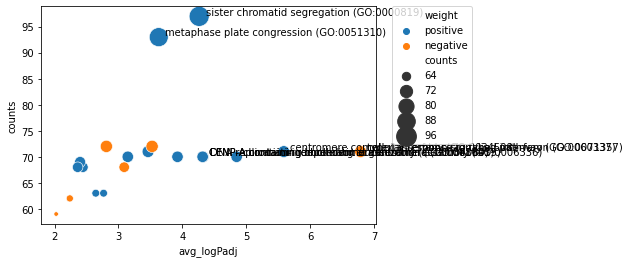

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(data=df_pathway_results,
                x='avg_logPadj',
                y='counts',
                hue='weight',
                sizes=(20, 400),
                size='counts')
for i, row in df_pathway_results.iterrows():
    if row.counts > 80 or row.avg_logPadj > 4:
        plt.text(x=row.avg_logPadj + 0.1, y=row.counts + 0.3, s=i)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)